In [134]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [135]:
fixtures = pd.read_pickle("../../data/processed/fixtures_with_ratings_latest.pkl")

In [136]:
first_10 = fixtures.loc[fixtures.gw < 11].rename(columns={'elo_outcome_rating_1':'elo_outcome_rating_p',
                                                         'elo_outcome_rating_2':'elo_outcome_rating_o',
                                                         'elo_outcome_rating_diff':'elo_outcome_rating_d',
                                                         'elo_outcome_rating_e':'elo_outcome_rating_ex'})

In [137]:
players_latest = pd.read_pickle('../../data/raw/cleaned_players_latest.pkl')

In [138]:
players_latest.columns

Index(['first_name', 'second_name', 'goals_scored', 'assists', 'total_points',
       'minutes', 'goals_conceded', 'creativity', 'influence', 'threat',
       'bonus', 'bps', 'ict_index', 'clean_sheets', 'red_cards',
       'yellow_cards', 'selected_by_percent', 'now_cost'],
      dtype='object')

In [139]:
gameweek_df = pd.read_pickle('../../data/gameweek_with_ma.pkl')

In [140]:
model_cv = pickle.load(open('../../models/lightgbm_all_data.pkl', 'rb'))
MODEL_VALS = pickle.load(open('../../models/lightgbm_model_cols.pkl','rb'))

In [141]:
first_10.columns

Index(['elo_outcome_rating_p', 'elo_outcome_rating_o', 'gw', 'is_home',
       'kickoff_time', 'opp_team', 'team', 'elo_outcome_rating_d',
       'elo_outcome_rating_ex'],
      dtype='object')

In [142]:
prev_season_df = (gameweek_df.sort_values(by='Date').drop_duplicates(['clean_name'],keep='last')[['Date','clean_name','team','pos']+MODEL_VALS]
.drop(columns=['gw','value','elo_outcome_rating_p',
 'elo_outcome_rating_o',
 'elo_outcome_rating_d',
 'elo_outcome_rating_ex',]))

In [143]:
players_latest['clean_name'] = players_latest.first_name + '_' + players_latest.second_name

In [144]:
combined_df = prev_season_df.merge(players_latest.loc[:,['selected_by_percent','now_cost','clean_name']],on='clean_name')

In [145]:
forecast_df = first_10.merge(combined_df,on='team')

In [146]:
forecast_df['value'] = forecast_df.now_cost

In [147]:
forecast_df['transfers_in'] = (forecast_df.transfers_in.mean() / forecast_df.selected_by_percent.mean() ) * forecast_df.selected_by_percent
forecast_df['transfers_out'] = 0
forecast_df['transfers_balance'] = forecast_df.transfers_in - forecast_df.transfers_out

In [148]:
forecast_df['score_forecast'] = model_cv.predict(forecast_df[MODEL_VALS])

In [149]:
selection_df = forecast_df.groupby(['clean_name','pos'])[['score_forecast','value','selected_by_percent']].mean().reset_index().sort_values(by='score_forecast',ascending=False)

In [150]:
selection_df.to_pickle('../../data/processed/live_selections.pkl')

In [153]:
selection_df.head(20)

,clean_name,pos,score_forecast,value,selected_by_percent
222,Lucas_Digne,DEF,6.317723,60,27.8
167,Jamie_Vardy,FWD,5.976189,90,11.3
22,Andrew_Robertson,DEF,5.948567,70,36.2
267,Mohamed_Salah,MID,5.915893,125,36.5
324,Sadio_Mané,MID,5.751974,115,24.8
378,Youri_Tielemans,MID,5.358895,65,5.7
337,Shane_Duffy,DEF,5.219849,50,3.3
226,Lukasz_Fabianski,GK,5.208505,50,10.2
305,Ricardo Domingos_Barbosa Pereira,DEF,5.103416,60,8.0
225,Luka_Milivojevic,MID,5.037805,70,13.0


In [154]:
import shap

In [155]:
def explain_player(player, model):
    print(player)
    explainer = shap.TreeExplainer(model)
    player_df =forecast_df.loc[forecast_df.clean_name==player,MODEL_VALS].iloc[[0],:]
    shap_values = explainer.shap_values(player_df)
    return shap.force_plot(explainer.expected_value, shap_values, player_df,matplotlib=True)
    

In [156]:
forecast_df.loc[forecast_df.clean_name=='Raheem_Sterling',MODEL_VALS].iloc[[0],:]

,elo_outcome_rating_p,elo_outcome_rating_o,elo_outcome_rating_d,elo_outcome_rating_ex,transfers_balance,transfers_in,transfers_out,value,was_home,position_DEF,...,ewma_team_h_score,ewma_threat,ewma_total_points,ewma_transfers_balance,ewma_transfers_in,ewma_transfers_out,ewma_value,ewma_was_home,ewma_winning_goals,ewma_yellow_cards
1341,1523.607762,1386.03652,137.571242,0.688244,69029.957171,69029.957171,0,120,False,0,...,1.495461,41.61354,5.938646,90668.805859,141401.957622,50733.151763,112.184058,0.502055,0.157812,0.093584


Raheem_Sterling


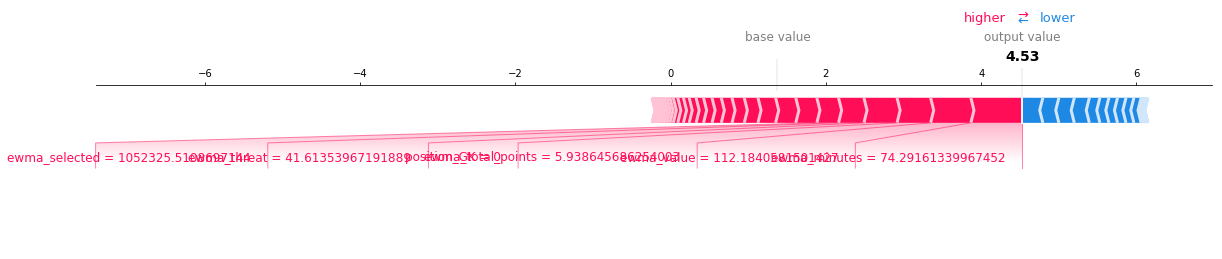

Harry_Kane


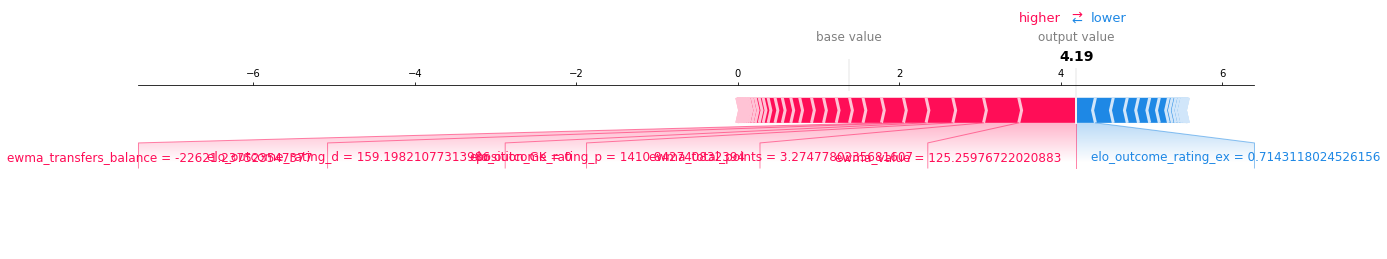

Trent_Alexander-Arnold


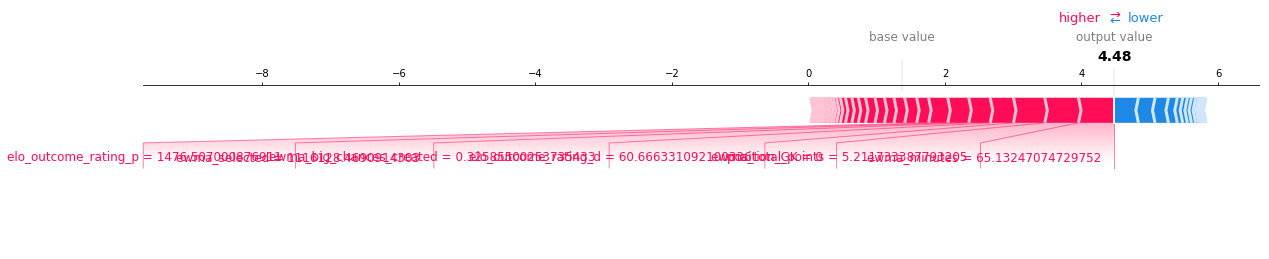

Sadio_Mané


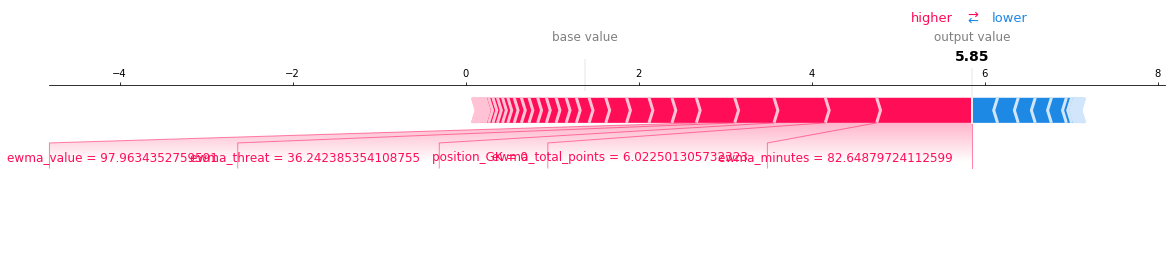

Ryan_Fraser


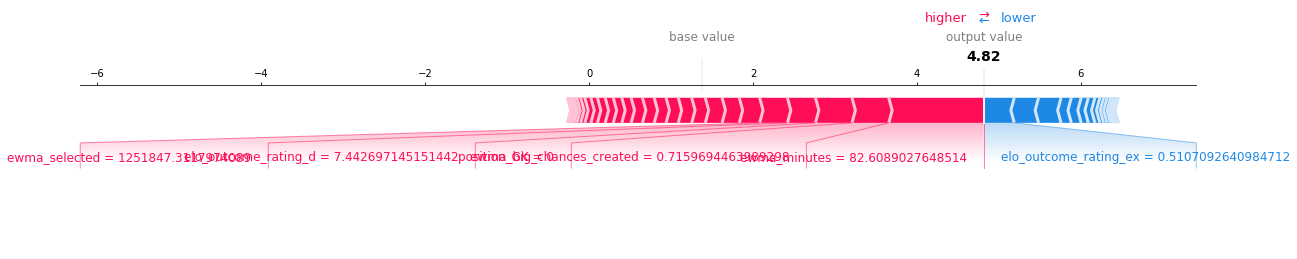

Jamie_Vardy


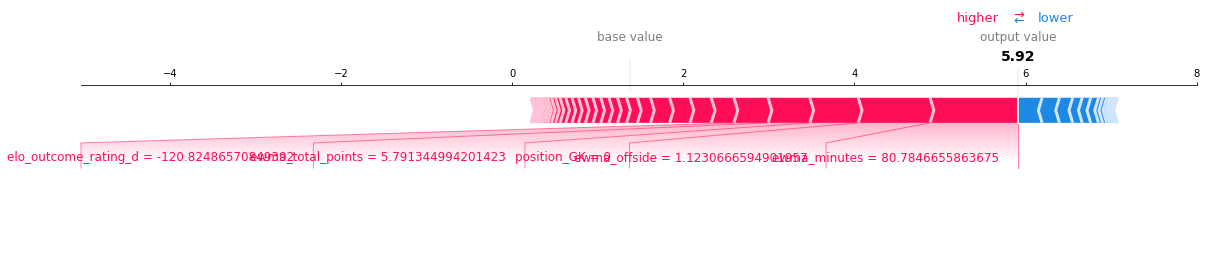

Shane_Duffy


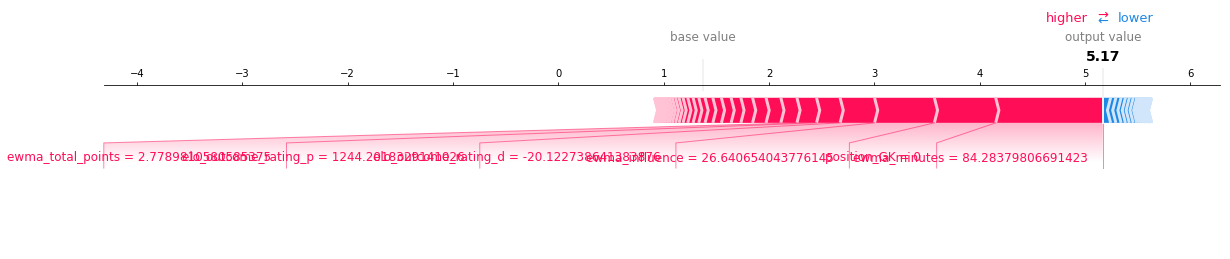

In [158]:
for p in ['Raheem_Sterling','Harry_Kane','Trent_Alexander-Arnold','Sadio_Mané','Ryan_Fraser','Jamie_Vardy','Shane_Duffy']:
    explain_player(p, model_cv)